
# Customer Segmentation of a French (C2C) Fashion Store Users

Segmentation of users of a french (C2C) fashion store using cluster analysis to achieve more effective customer marketing via personalization. The result is present as Tableau dashboard. Process is automated for using with subsequent data.

The focus of the  project is customers who are active  users of the platform in selling field. To be consider as an active user, they should have at least one listed, sold, bought, liked or wishes product.

Due to large number location of customers and very differernt level of using the platform, countries where less then 1% of users located are regarded as  'Other' in analysis.



## Importing packages, loading the data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn import cluster, tree, decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

# Download the dataset
# Source https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
fl = '2. Prepared Data/6M-0K-99K.users.dataset.public.csv'
data = pd.read_csv(fl)

# Preview data
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9006282053848196165,user,Suède,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2858299215060733023,user,France,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr


## 1. Data Preprocessing

### 1.1. Exploratory Data Analysis & Data Cleaning

In [2]:
# Get base information on the dataset
data.columns

Index(['identifierHash', 'type', 'country', 'language', 'socialNbFollowers',
       'socialNbFollows', 'socialProductsLiked', 'productsListed',
       'productsSold', 'productsPassRate', 'productsWished', 'productsBought',
       'gender', 'civilityGenderId', 'civilityTitle', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'seniorityAsMonths', 'seniorityAsYears', 'countryCode'],
      dtype='object')

In [3]:
# Drop columns with information that will not be used or is duplicated 
drop_columns = ['productsPassRate', 'civilityGenderId', 'civilityTitle', 'seniorityAsMonths', 'seniorityAsYears','countryCode']
data.drop(columns=drop_columns, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   identifierHash       98913 non-null  int64 
 1   type                 98913 non-null  object
 2   country              98913 non-null  object
 3   language             98913 non-null  object
 4   socialNbFollowers    98913 non-null  int64 
 5   socialNbFollows      98913 non-null  int64 
 6   socialProductsLiked  98913 non-null  int64 
 7   productsListed       98913 non-null  int64 
 8   productsSold         98913 non-null  int64 
 9   productsWished       98913 non-null  int64 
 10  productsBought       98913 non-null  int64 
 11  gender               98913 non-null  object
 12  hasAnyApp            98913 non-null  bool  
 13  hasAndroidApp        98913 non-null  bool  
 14  hasIosApp            98913 non-null  bool  
 15  hasProfilePicture    98913 non-null  bool  
 16  days

In [4]:
# Get the dimensionality of the dataset
print(data.shape)

(98913, 18)


In [5]:
# Check that user identification numbers are unique
users = len(data['identifierHash'].unique().tolist())
print(f'Duplicated users: {users-data.shape[0]}')

# Chech type of users is 'user' 
user_types = (data['type']=='user').sum() - data.shape[0]

# Drop 'type' column if type of all users is 'user' 
if user_types==0:
    data.drop(columns='type', inplace=True)
    
# Drop rows if type of users is different from 'user'
# Then drop 'type' column
else:
    other_types = data['type']!='user'
    data.drop(data[other_types].index, inplace=True)
    data.drop(columns='type', inplace=True)

Duplicated users: 0


In [6]:
# Check duplicated rows
print(f'Duplicated rows : {data.duplicated().sum()}')

Duplicated rows : 0


In [7]:
# Find missing values 
print(f'Missing values: {data.isnull().sum().sum()}')

Missing values: 0


In [8]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numeric_cols = data.select_dtypes([np.int64,np.float64]).columns.tolist()
print (f'Numeric: {len(numeric_cols)} \n{numeric_cols}')

categorical_cols = data.select_dtypes([np.object]).columns.tolist()
print (f'Categorical: {len(categorical_cols)} \n{categorical_cols}')

booleans_cols = data.select_dtypes([np.bool]).columns.tolist()
print (f'Boolean: {len(booleans_cols)} \n{booleans_cols}')

Columns
Numeric: 10 
['identifierHash', 'socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority']
Categorical: 3 
['country', 'language', 'gender']
Boolean: 4 
['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture']


In [9]:
# Filter data of active users, who sold, bought, wished or liked products

###################################### FILTER ################################################

# List of columns related to user activity in selling of products
products = ['socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought']
# Calculate sum across rows
data['productSum'] = data[products].sum(axis=1)

# Filter data of user who have any activity (sum > 0)
data = data[data['productSum'] > 0]

# Drop utility 'productSum' column
data.drop(columns='productSum', inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

# Preview data
data.head()

,identifierHash,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority
0,-7877915015908472168,Royaume-Uni,en,3,8,4,0,0,0,0,F,False,False,False,True,591,3205
1,-8231936648814680895,Danemark,en,3,8,370,0,0,1,0,F,False,False,False,True,42,3205
2,5663923945758514393,Etats-Unis,en,3,8,1,0,0,0,0,F,False,False,False,True,32,3205
3,-3483039296670050121,Allemagne,de,3,8,27,0,0,0,0,M,True,False,True,True,669,3205
4,3451396970677435825,Suisse,en,3,8,0,0,0,9,0,F,True,True,False,True,463,3205


In [10]:
# Get the dimensionality of the dataset
print(data.shape)

(21639, 17)


In [11]:
# Get statistics for numeric columns
data.drop(columns='identifierHash').describe() 

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsWished,productsBought,daysSinceLastLogin,seniority
count,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,4.557558,9.911271,20.207450,0.426498,0.555802,7.142705,0.785896,384.445631,3063.934979
std,8.155680,112.960063,386.638353,4.367049,4.520774,53.491932,4.937857,271.408591,168.278417
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2852.000000
25%,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,2857.000000
50%,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,401.000000,3196.000000
75%,4.000000,8.000000,6.000000,0.000000,0.000000,2.000000,1.000000,680.000000,3201.000000
max,744.000000,13764.000000,51671.000000,244.000000,174.000000,2635.000000,405.000000,709.000000,3205.000000


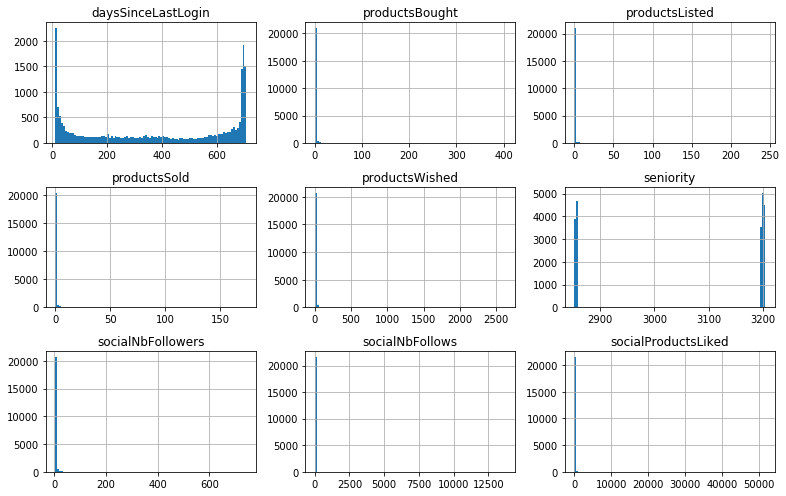

In [12]:
# Plot the distribution of numerical columns

# Create list of numerical columns for plots
# Copy the list of numerical columns
numeric_cols_plot = numeric_cols.copy()
# Remove the 'identifierHash' column
numeric_cols_plot.remove('identifierHash')
# Plot histograms
data[numeric_cols_plot].hist(figsize=(11,7), bins=100)
plt.tight_layout()

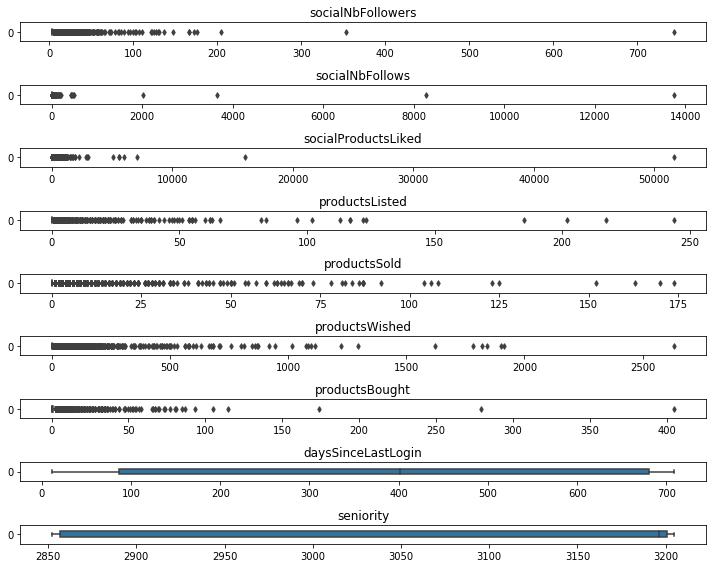

In [13]:
# Plot boxplots

fig, axes = plt.subplots(nrows=len(numeric_cols_plot),ncols=1,figsize=(10,8))
for index, column in enumerate(numeric_cols_plot):
    ax=sns.boxplot(data=data[column],orient='h', ax=axes[index], width=0.3, fliersize=4, color=color)
    ax.set_title(data[column].name)

plt.tight_layout()

In [14]:
# Generate pairplot
#sns.pairplot(data[numeric_cols].drop(columns=drop_num_cols))

Text(0.5, 1, 'Correlation Matrix')

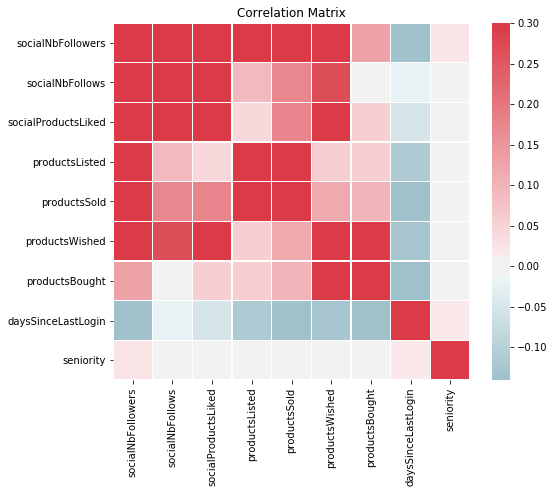

In [15]:
# Generate our corelation plot or heatmap
corr = data[numeric_cols_plot].corr()
# Generate heatmap
plt.figure(figsize = (8,8))
cmap = sns.diverging_palette(220,10,as_cmap = True)

sns.heatmap(corr,xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,cmap=cmap,vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Correlation Matrix')

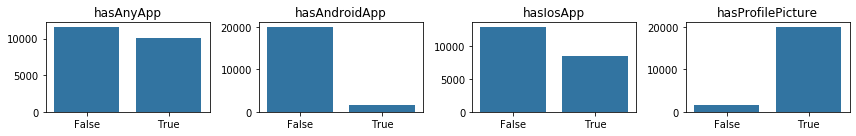

In [16]:
# Plot booleans data
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2))
for index, column in enumerate(booleans_cols):
    ax=sns.countplot(x=data[column],orient='h', ax=axes[index], color=color)
    ax.set_title(data[column].name)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()

In [17]:
# Plot categorical data
# Count number of countries
countries_number = len(data['country'].unique().tolist())
print(f'Countries: {countries_number}')

# Translate the list of countries into English 
data['country'] = data['country'].replace({
     'Royaume-Uni':'UK', 'Danemark':'Denmark','Etats-Unis':'US', 'Allemagne':'Germany', 
     'Suisse':'Swiss','Suède':'Sweden','Australie':'Australia','Italie':'Italy', 'Espagne':'Spain', 
     'Finlande':'Finland','Belgique':'Belgium','Pays-Bas':'Netherlands', 'Autriche':'Austria', 
    'Russie':'Russia', 'Bulgarie':'Bulgaria', 'Chine':'China', 'Irlande': 'Ireland', 'Roumanie':'Romania'})

# Group users by country
countries=pd.DataFrame(data['country'].value_counts()).sort_values(by='country',ascending=False)
countries.rename(columns={'country':'users'}, inplace=True)
# Calculate % of total users by country
countries['users_%_total'] = round(countries['users']/countries['users'].sum(),3)*100

# Number of users by country
users_20 = countries.head(20)
users_20

Countries: 127


,users,users_%_total
France,4972,23.0
US,3927,18.1
UK,2555,11.8
Italy,1993,9.2
Germany,1835,8.5
Spain,1048,4.8
Australia,631,2.9
Denmark,614,2.8
Sweden,497,2.3
Netherlands,482,2.2


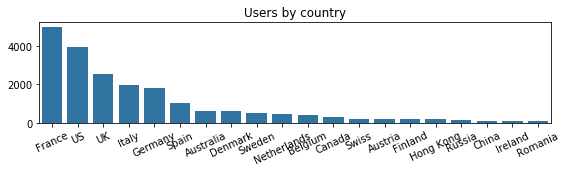

In [18]:
# Plot categorical data
fig, ax1 = plt.subplots(figsize=(8,2.5))

sns.barplot(x=users_20.index, y=users_20['users'], color=color, ax=ax1)

ax1.set_title('Users by country')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.xaxis.set_tick_params(rotation=25)

plt.tight_layout()

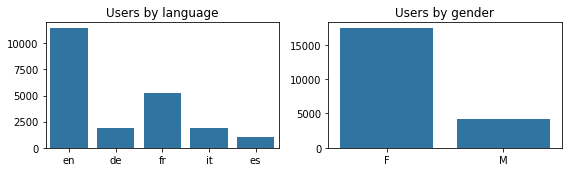

In [19]:
# Plot categorical data
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(8,2.5))

sns.countplot(x=data['language'],orient='h', color=color, ax=ax1)
sns.countplot(x=data['gender'],orient='h', color=color, ax=ax2)

ax1.set_title('Users by language')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_title('Users by gender')
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()

In [20]:
# Selling by country
selling_filter = (data['productsListed']==0) & (data['productsSold']==0)
selling_data = data[~selling_filter]
selling_data_group=selling_data.groupby('country')[['productsSold', 'productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).reset_index()
selling_data_group['%sold']=round(selling_data_group[('productsSold', 'sum')]/selling_data_group[('productsSold', 'sum')].sum(),3)*100
selling_data_group['%listed']=round(selling_data_group[('productsListed', 'sum')]/selling_data_group[('productsListed', 'sum')].sum(),3)*100
selling_top10=selling_data_group.nlargest(10,('productsSold', 'sum'))
# Start the index from 1
selling_top10.index=selling_top10.index+1
print('Products sold by top 10 countries')
selling_top10

Products sold by top 10 countries


,country,productsSold,productsListed,%sold,%listed
,,sum,sum,,
1,France,3014,2242,25.1,24.3
2,Italy,2820,2401,23.4,26.0
3,UK,1806,1025,15.0,11.1
4,Spain,990,667,8.2,7.2
5,US,967,962,8.0,10.4
6,Germany,536,349,4.5,3.8
7,Sweden,336,237,2.8,2.6
8,Netherlands,214,157,1.8,1.7
9,Monaco,190,27,1.6,0.3


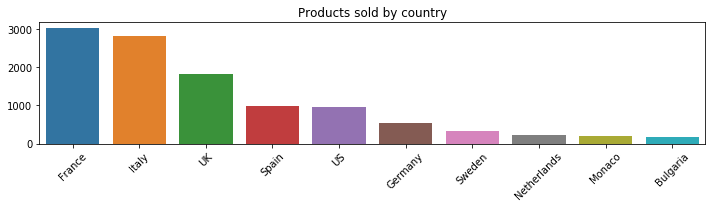

In [21]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=selling_top10['country'],y=selling_top10[('productsSold', 'sum')])
ax.set_title('Products sold by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [22]:
# Verification Selling
#data.groupby('country')[[ 'productsSold','productsListed']].agg(['sum']).sort_values(by=('productsSold', 'sum'), ascending=False).T

In [23]:
# Buying by country
buying_filter = (data['socialProductsLiked']==0) & (data['productsWished']==0) & (data['productsBought']==0)
buying_data = data[~buying_filter]
buying_data_group=buying_data.groupby('country')[['productsBought','socialProductsLiked', 'productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).reset_index()
buying_data_group['%bought']=round(buying_data_group[('productsBought', 'sum')]/buying_data_group[('productsBought', 'sum')].sum(),3)*100
buying_data_group['%liked']=round(buying_data_group[('socialProductsLiked', 'sum')]/buying_data_group[('socialProductsLiked', 'sum')].sum(),3)*100
buying_data_group['%wished']=round(buying_data_group[('productsWished', 'sum')]/buying_data_group[('productsWished', 'sum')].sum(),3)*100
buying_top10=buying_data_group.nlargest(10,('productsBought', 'sum'))
# Start the index from 1
buying_top10.index=buying_top10.index+1
print('Products bought by top 10 countries')
buying_top10

Products bought by top 10 countries


,country,productsBought,socialProductsLiked,productsWished,%bought,%liked,%wished
,,sum,sum,sum,,,
1,France,3573,55969,21790,21.0,12.8,14.1
2,US,2370,54090,17567,13.9,12.4,11.4
3,UK,2174,35199,18469,12.8,8.0,11.9
4,Germany,1635,33568,15477,9.6,7.7,10.0
5,Italy,1221,85239,17264,7.2,19.5,11.2
6,Spain,1028,26213,10245,6.0,6.0,6.6
7,Belgium,718,5164,4083,4.2,1.2,2.6
8,Sweden,566,20539,6743,3.3,4.7,4.4
9,Netherlands,537,10669,3934,3.2,2.4,2.5


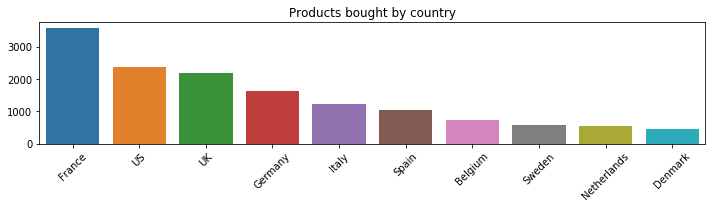

In [24]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(x=buying_top10['country'],y=buying_top10[('productsBought', 'sum')])
ax.set_title('Products bought by country')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [25]:
# Verification Buying
#data.groupby('country')[['productsBought','socialProductsLiked','productsWished']].agg(['sum']).sort_values(by=('productsBought', 'sum'), ascending=False).T

### 1.2. Feature Engineering

In [26]:
# Set limits for columns 

# Limits for columns
max_lim_followers = 100
max_lim_follows = 100
max_lim_liked = 1500
max_lim_wished = 1000
max_lim_lastLogin = 670 # ~1 year and 10 months

# The list of columns where limits are set
social = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsWished'] 
# The list of limits that were set
max_lim = [max_lim_followers, max_lim_follows, max_lim_liked, max_lim_wished]

social_active_users = data[(data['socialNbFollowers']>=max_lim_followers) | 
                                  (data['socialNbFollows']>=max_lim_follows) | 
                                  (data['socialProductsLiked']>=max_lim_liked) | 
                                  (data['productsWished']>=max_lim_wished)]

print(f'Sotial active users: {len(social_active_users)}')

# Utility functions
def getMaxLimitOfColumn(social, max_lim):
    """ Creates a list of tuples from a list of column names and a list of limit values. """
    values = []
    for value in zip(social, max_lim):
        values.append(value)
    return values

x = getMaxLimitOfColumn(social, max_lim)
print(f'Limits of features: {x}')

def setMaxLimToColumn(value, limit):
    """ Extracts integer part of number, divided by 5, if its less then the limit, otherwise extracts the limit divided by 5. """
    if value >= limit:
        return int(limit/5)
    else: 
        return int(value/5)

# Create new columns with values in units of 5 (divided by 5)
data['socialNbFollowers_UN']=data['socialNbFollowers'].apply(lambda x: setMaxLimToColumn(x, max_lim_followers))
data['socialNbFollows_UN']=data['socialNbFollows'].apply(lambda x: setMaxLimToColumn(x, max_lim_follows))
data['socialProductsLiked_UN']=data['socialProductsLiked'].apply(lambda x: setMaxLimToColumn(x, max_lim_liked))
data['productsWished_UN']=data['productsWished'].apply(lambda x: setMaxLimToColumn(x, max_lim_wished))

# Create new column with values in units of 30 (divided by 30)
data['daysSinceLastLogin_UN'] = data['daysSinceLastLogin'].apply(lambda x: int(max_lim_lastLogin/30) if x>= max_lim_lastLogin else int(x/30))

# The list of created columns
social_UN = ['socialNbFollowers_UN','socialNbFollows_UN','socialProductsLiked_UN','productsWished_UN', 'daysSinceLastLogin_UN']

Sotial active users: 52
Limits of features: [('socialNbFollowers', 100), ('socialNbFollows', 100), ('socialProductsLiked', 1500), ('productsWished', 1000)]


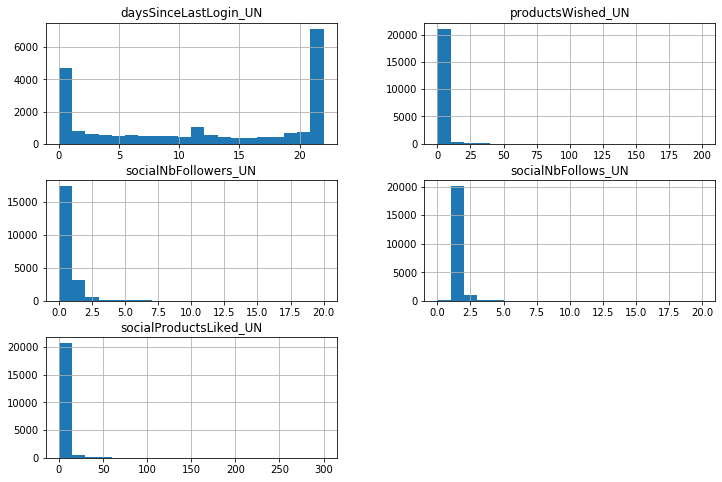

In [27]:
data[social_UN].hist(figsize=(12,8), bins=20)
plt.show()

In [28]:
# Save the rows where the data will be changed
social_active_users = data[(data['socialNbFollowers']>=max_lim_followers) | 
                                  (data['socialNbFollows']>=max_lim_follows) | 
                                  (data['socialProductsLiked']>=max_lim_liked) | 
                                  (data['productsWished']>=max_lim_wished)]
# Save social active users data to a excel file
social_active_users.to_excel("4. Analysis/classification_e-commerce_social_active_users_rows.xlsx")

social_active_users_lastLogin = data[(data['daysSinceLastLogin']>=max_lim_lastLogin)]  
                                     
# Save social active users data to a excel file
social_active_users_lastLogin.to_excel("4. Analysis/classification_e-commerce_social_active_users_lastLogin_rows.xlsx")

In [29]:
# Define countries as 'Other', if % of users is less then 1%
users_perc_lim = 1
other_countries = countries[countries['users_%_total']<users_perc_lim].index.tolist()
print(f'Other countries: {len(other_countries)}')
#print(other_countries)
data['country_short_list']=data['country'].apply(lambda x: 'Other' if x in other_countries else x)
countries_list = data['country_short_list'].unique().tolist()
print(f'Countries short list: {countries_list}')

Other countries: 114
Countries short list: ['UK', 'Denmark', 'US', 'Germany', 'Swiss', 'France', 'Other', 'Sweden', 'Canada', 'Australia', 'Italy', 'Spain', 'Belgium', 'Netherlands']


In [30]:
# Change the boolean column type to integer
data[booleans_cols]=data[booleans_cols].astype(int)

# Duplicate columns
data['language_c']=data['language']
# Convert categorical variable into dummy/indicator variables
cat_features =['language', 'gender', 'country_short_list']
data = pd.get_dummies(data, columns=cat_features)

# Rename columns
data.rename(columns={'language_c': 'language'}, inplace=True)

# Preview data
data.drop(columns=['identifierHash']).head()

# Check that 'hasAnyApp' is 'hasAndroidApp' or 'hasIosApp'
(data['hasAndroidApp']+data['hasIosApp']-data['hasAnyApp']).isnull().sum()

0

In [31]:
data.drop('identifierHash', axis=1).head()

,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
0,UK,3,8,4,0,0,0,0,0,0,0,1,591,3205,0,1,0,0,19,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Denmark,3,8,370,0,0,1,0,0,0,0,1,42,3205,0,1,74,0,1,en,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,US,3,8,1,0,0,0,0,0,0,0,1,32,3205,0,1,0,0,1,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Germany,3,8,27,0,0,0,0,1,0,1,1,669,3205,0,1,5,0,22,de,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Swiss,3,8,0,0,0,9,0,1,1,0,1,463,3205,0,1,0,1,15,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [32]:
# Save the preprocessed data to a csv file
file = '2. Prepared Data/classification_e-commerce_preprocessed_data.csv'
data.to_csv(file, index = False)
data.shape

(21639, 42)

## 3. Clustering

### Features 

In [33]:
data.columns

Index(['identifierHash', 'country', 'socialNbFollowers', 'socialNbFollows',
       'socialProductsLiked', 'productsListed', 'productsSold',
       'productsWished', 'productsBought', 'hasAnyApp', 'hasAndroidApp',
       'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin', 'seniority',
       'socialNbFollowers_UN', 'socialNbFollows_UN', 'socialProductsLiked_UN',
       'productsWished_UN', 'daysSinceLastLogin_UN', 'language', 'language_de',
       'language_en', 'language_es', 'language_fr', 'language_it', 'gender_F',
       'gender_M', 'country_short_list_Australia',
       'country_short_list_Belgium', 'country_short_list_Canada',
       'country_short_list_Denmark', 'country_short_list_France',
       'country_short_list_Germany', 'country_short_list_Italy',
       'country_short_list_Netherlands', 'country_short_list_Other',
       'country_short_list_Spain', 'country_short_list_Sweden',
       'country_short_list_Swiss', 'country_short_list_UK',
       'country_short_list_US'],

In [34]:
features = ['productsBought', 'productsListed', 'productsSold', 
            'socialNbFollowers_UN', 'socialNbFollows_UN', 'socialProductsLiked_UN', 'productsWished_UN',
            'daysSinceLastLogin_UN', 
            'hasAnyApp','language_de', 'language_en', 'language_es', 'language_fr', 'language_it'] 
           

df_features=data[features + ['country']]

# Preview data
df_features.head()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,country
0,0,0,0,0,1,0,0,19,0,0,1,0,0,0,UK
1,0,0,0,0,1,74,0,1,0,0,1,0,0,0,Denmark
2,0,0,0,0,1,0,0,1,0,0,1,0,0,0,US
3,0,0,0,0,1,5,0,22,1,1,0,0,0,0,Germany
4,0,0,0,0,1,0,1,15,1,0,1,0,0,0,Swiss


### Standardizing data

In [35]:
df = df_features.copy()
#df[features] = StandardScaler().fit_transform(df[features])
df[features] = RobustScaler().fit_transform(df[features])
X = df[features] 

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X)

df.head()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,country
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30,0.0,0.0,0.0,0.0,0.0,0.0,UK
1,0.0,0.0,0.0,0.0,0.0,74.0,0.0,-0.60,0.0,0.0,0.0,0.0,0.0,0.0,Denmark
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.60,0.0,0.0,0.0,0.0,0.0,0.0,US
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.45,1.0,1.0,-1.0,0.0,0.0,0.0,Germany
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,1.0,0.0,0.0,0.0,0.0,0.0,Swiss


### K-means clustering

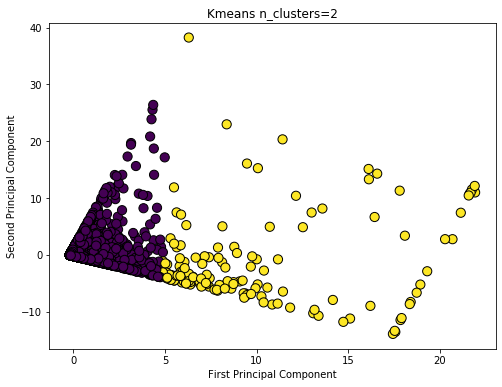

Kmeans:
For n_clusters=2, The Silhouette Coefficient: 0.9527860410732297


In [36]:
# KMeans with 2 clusters 
km = cluster.KMeans(n_clusters=2, max_iter=300, random_state=None)
labels = km.fit_predict(X)
n_clusters = km.n_clusters

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, edgecolors='k', s=84)
plt.title(f'Kmeans n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


print('Kmeans:')
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}')

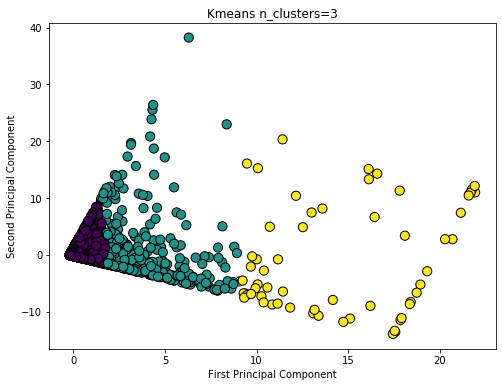

Kmeans:
For n_clusters=3, The Silhouette Coefficient: 0.9086417352755429


In [37]:
# KMeans with 3 clusters 
km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
labels = km.fit_predict(X)
n_clusters = km.n_clusters

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, edgecolors='k', s=84)
plt.title(f'Kmeans n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


print('Kmeans:')
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}') 

### Elbow method

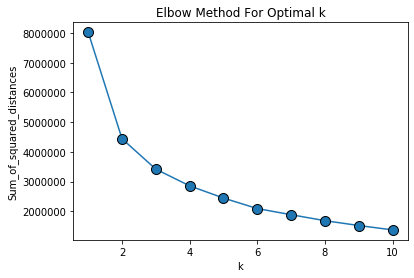

In [38]:
# Determining the optimal number of clusters

# Elbow method
sum_of_squared_distances = []

# Use k from 1 to 20
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=300, random_state=None)
    km = km.fit(X)
    # Get sum of square distances by applying km.inertia_ 
    sum_of_squared_distances.append(km.inertia_)

# Plot Results
plt.plot(K, sum_of_squared_distances, marker='o',  markeredgecolor='k', markersize=10)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Silhouette method

In [39]:
# Silhouette method

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    print(f'For n_clusters={n_cluster}, The Silhouette Coefficient: {sil_coeff}') 

For n_clusters=2, The Silhouette Coefficient: 0.9527860410732297
For n_clusters=3, The Silhouette Coefficient: 0.9098919921207321
For n_clusters=4, The Silhouette Coefficient: 0.9205641923654643
For n_clusters=5, The Silhouette Coefficient: 0.8483702079507215
For n_clusters=6, The Silhouette Coefficient: 0.8388777967526306
For n_clusters=7, The Silhouette Coefficient: 0.8384421861640685
For n_clusters=8, The Silhouette Coefficient: 0.8005050118686924
For n_clusters=9, The Silhouette Coefficient: 0.8010418947383373
For n_clusters=10, The Silhouette Coefficient: 0.7889782617705628


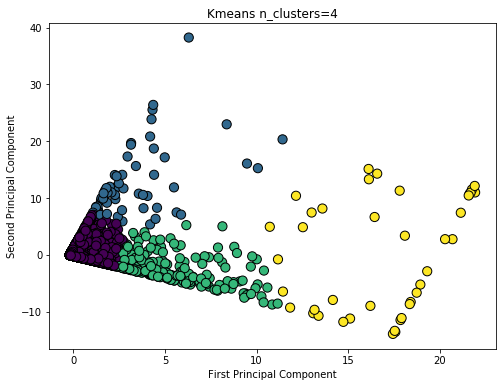

Kmeans:
For n_clusters=4, The Silhouette Coefficient: 0.9205542480377441


In [40]:
# KMeans with 4 clusters 
km = cluster.KMeans(n_clusters=4, max_iter=300, random_state=None)
labels = km.fit_predict(X)
n_clusters = km.n_clusters

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, edgecolors='k', s=84)
plt.title(f'Kmeans n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Kmeans:')
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}')

In [41]:
# Set clasters to the DataFrame
df['KMeans']=labels
# Combine DataFrames in result DataFrame
result = pd.concat([df_features, df['KMeans']], axis=1)

# Save the Kmeans clusters data to a csv file
file = '5. Insights/classification_e-commerce_KMeans_clusters.csv'
data.to_csv(file, index = False)

#### Profile and Inspection  of Kmeans clusters

In [42]:
print(result['KMeans'].value_counts())

0    21303
2      239
1       57
3       40
Name: KMeans, dtype: int64


In [43]:
result[result['KMeans']==0].describe()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,KMeans
count,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.000000,21303.0
mean,0.601230,0.375487,0.496033,0.301366,1.086795,1.499554,0.662113,12.306764,0.458574,0.089377,0.528001,0.047928,0.245740,0.088955,0.0
std,2.498985,3.840457,4.102694,0.991638,0.598896,4.405283,3.232355,8.784151,0.498293,0.285294,0.499227,0.213618,0.430535,0.284685,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,13.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,22.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
max,93.000000,244.000000,174.000000,20.000000,20.000000,43.000000,55.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [44]:
result[result['KMeans']==1].describe()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,KMeans
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0
mean,32.561404,2.052632,4.631579,2.508772,2.684211,21.210526,104.596491,0.578947,0.666667,0.087719,0.578947,0.035088,0.175439,0.122807,1.0
std,65.482282,6.045722,14.516778,2.673433,3.134815,29.548832,48.017430,1.981588,0.475595,0.285401,0.498117,0.185637,0.383723,0.331133,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,4.000000,0.000000,0.000000,1.000000,1.000000,1.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,11.000000,0.000000,0.000000,2.000000,1.000000,8.000000,93.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
75%,32.000000,2.000000,1.000000,3.000000,4.000000,32.000000,134.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0
max,405.000000,39.000000,82.000000,14.000000,20.000000,119.000000,200.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


### DBSCAN clustering

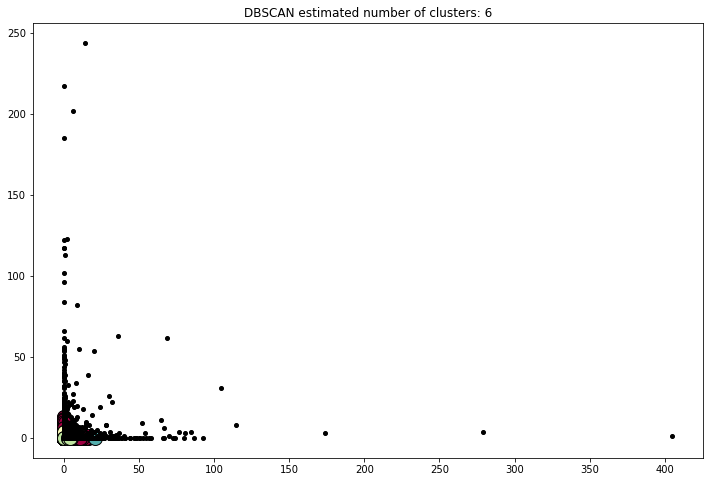

DBSCAN:
Estimated number of clusters: 6
Silhoette Coefficient: 0.7162463338944678


In [45]:
# DBSCAN
# Set up the data
df_std = df.copy()
X = df_std[features]
# Scale and standardize the data
#X = StandardScaler().fit_transform(X)
X = RobustScaler().fit_transform(df[features])
# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=3.275, min_samples = 7).fit(X)

# Store tha labels formed by the DBSCAN
labels = dbscan.labels_

# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Identify the core samples
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbscan.core_sample_indices_] = True

# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(12,8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

plt.title('DBSCAN estimated number of clusters: %d' % n_clusters_)
plt.show()

print('DBSCAN:')
print(f'Estimated number of clusters: {n_clusters_}')
# Silhouette Score
print(f'Silhoette Coefficient: {metrics.silhouette_score(X, labels)}')

In [46]:
# Set clasters to the DataFrame
df['DBSCAN']=labels
# Combine DataFrames in result DataFrame
result_dbs = pd.concat([df_features, df['DBSCAN']], axis=1)

#### Profile and Inspect DBSCAN clusters

In [47]:
print(result_dbs['DBSCAN'].value_counts())

 0    20653
-1      933
 4       17
 2       14
 1       10
 3        8
 5        4
Name: DBSCAN, dtype: int64


In [48]:
result_dbs[result_dbs['DBSCAN']==0].describe()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,DBSCAN
count,20653.000000,20653.000000,20653.000000,20653.000000,20653.000000,20653.000000,20653.000000,20653.000000,20653.000000,20653.00000,20653.000000,20653.000000,20653.000000,20653.000000,20653.0
mean,0.410594,0.140803,0.193628,0.218322,1.054859,1.233041,0.369874,12.631627,0.451605,0.08943,0.528785,0.048080,0.247276,0.086428,0.0
std,1.119920,0.777384,1.008839,0.611268,0.275443,3.726910,1.509405,8.690281,0.497664,0.28537,0.499183,0.213941,0.431439,0.281002,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,14.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,22.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.0
max,19.000000,15.000000,17.000000,8.000000,6.000000,44.000000,21.000000,22.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0


In [49]:
result_dbs[result_dbs['DBSCAN']==1].describe()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,DBSCAN
count,10.00000,10.0,10.0,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.0
mean,0.90000,0.0,0.0,0.400000,1.0,62.100000,0.300000,4.500000,0.800000,0.100000,0.500000,0.0,0.200000,0.200000,1.0
std,1.37032,0.0,0.0,0.699206,0.0,0.994429,0.674949,6.900081,0.421637,0.316228,0.527046,0.0,0.421637,0.421637,0.0
min,0.00000,0.0,0.0,0.000000,1.0,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,0.00000,0.0,0.0,0.000000,1.0,61.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,0.00000,0.0,0.0,0.000000,1.0,62.000000,0.000000,1.500000,1.000000,0.000000,0.500000,0.0,0.000000,0.000000,1.0
75%,1.75000,0.0,0.0,0.750000,1.0,62.750000,0.000000,4.750000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.0
max,4.00000,0.0,0.0,2.000000,1.0,64.000000,2.000000,21.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0


In [50]:
result_dbs[result_dbs['DBSCAN']==2].describe()

,productsBought,productsListed,productsSold,socialNbFollowers_UN,socialNbFollows_UN,socialProductsLiked_UN,productsWished_UN,daysSinceLastLogin_UN,hasAnyApp,language_de,language_en,language_es,language_fr,language_it,DBSCAN
count,14.000000,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.0,14.0
mean,0.785714,0.0,0.071429,0.428571,1.142857,51.571429,0.357143,3.357143,0.857143,0.071429,0.714286,0.0,0.214286,0.0,2.0
std,1.188313,0.0,0.267261,0.646206,0.363137,2.310987,0.633324,5.637882,0.363137,0.267261,0.468807,0.0,0.425815,0.0,0.0
min,0.000000,0.0,0.000000,0.000000,1.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2.0
25%,0.000000,0.0,0.000000,0.000000,1.000000,49.250000,0.000000,0.000000,1.000000,0.000000,0.250000,0.0,0.000000,0.0,2.0
50%,0.000000,0.0,0.000000,0.000000,1.000000,52.000000,0.000000,1.500000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,2.0
75%,1.750000,0.0,0.000000,1.000000,1.000000,53.000000,0.750000,3.750000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,2.0
max,3.000000,0.0,1.000000,2.000000,2.000000,55.000000,2.000000,20.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,2.0


In [51]:
# Save the DBSCAN clusters data to a csv file
#file = '5. Insights/classification_e-commerce_DBSCAN_clusters.csv'
#data.to_csv(file, index = False)